In [1]:
import requests
import pandas as pd
import os
from dotenv import load_dotenv
import datetime as dt
import calendar
from datetime import datetime, timedelta

import seaborn as sns

In [2]:
#Data cleanning and ordering function DON`T delete
def df_nearobjects(df, date):
    df = pd.DataFrame(df[date])
    
    #Link
    link = df.links.apply(lambda x: x['self'])
    
    #Min diameter in KM
    min_diameter = df.estimated_diameter.apply(lambda x: x['kilometers']['estimated_diameter_min'])
    
    #Max diameter in KM
    max_diameter = df.estimated_diameter.apply(lambda x: x['kilometers']['estimated_diameter_max'])
    
    #Clase date to earth
    close_date = df.close_approach_data.apply(lambda x: x[0]['close_approach_date'])

    #Velocity in km per hour
    relative_vel_kmperhour = df.close_approach_data.apply(lambda x: x[0]['relative_velocity']['kilometers_per_hour'])
    orbit_object = df.close_approach_data.apply(lambda x: x[0]['orbiting_body'])

    #Distance needed to cause damage
    miss_distance_km = df.close_approach_data.apply(lambda x: x[0]['miss_distance']['kilometers'])
    
    #Join new info
    df = df.join(link, rsuffix='lk')
    df = df.join(min_diameter, rsuffix='min_')
    df = df.join(max_diameter, lsuffix='max_')
    df = df.join(close_date, lsuffix='date')
    df = df.join(relative_vel_kmperhour, lsuffix='perhour')
    df = df.join(orbit_object, lsuffix='obj')
    df = df.join(miss_distance_km, lsuffix='disty')
    
    #Filter 
    df = df[['id', 'neo_reference_id', 'name', 'nasa_jpl_url',
       'absolute_magnitude_h', 'is_potentially_hazardous_asteroid',
       'is_sentry_object', 'estimated_diametermin_', 'estimated_diameter',
       'close_approach_dataperhour', 'close_approach_dataobj',
       'close_approach_datadisty', 'close_approach_data']]
    
    #Column rename
    df.columns = [['id', 'neo_reference_id', 'name', 'nasa_jpl_url',
       'absolute_magnitude_h', 'is_potentially_hazardous_asteroid',
       'is_sentry_object', 'min_diameter_km', 'max_diameter_km',
       'close_date', 'relative_velocity_perhour',
       'orbit_object', 'missing_distance_km']]
                   
    return df

In [3]:
#Date ranges per week for selecting API dates

dict_dates = {}

start_date = datetime(2022, 1, 1)
end_date = datetime(2022, 12, 31)
current_date = start_date
while current_date <= end_date:
    dict_dates[current_date.strftime(format='%Y-%m-%d')] = (current_date + timedelta(days=6)).strftime(format='%Y-%m-%d')
    current_date += timedelta(days=7)

In [4]:
df_asteroids = []

load_dotenv()
key = os.getenv('KEY')

for start, end in dict_dates.items():
    url = f'https://api.nasa.gov/neo/rest/v1/feed?start_date={start}&end_date={end}&api_key={key}'

    req = requests.get(url)

    data = req.json()
    near_objects = data.get('near_earth_objects')
    df_asteroids.append(near_objects)

In [5]:
l = []

for i in range(len(df_asteroids)):
    for x in df_asteroids[i].keys():
        l.append(df_nearobjects(df_asteroids[i], x))
        
data_ast = pd.concat(l)

In [6]:
data_ast= pd.DataFrame(data_ast)

In [7]:
#Reset index
data_ast = data_ast.sort_values(data_ast.columns[-4])
data_ast.reset_index(inplace=True, drop=True)

#Drop column levels
data_ast.columns = data_ast.columns.to_flat_index()

In [8]:
#Fix column names affected by multilevel
data_ast.columns = ['id',
                    'neo_reference_id',
                    'name',
                    'nasa_jpl_url',
                    'absolute_magnitude_h',
                    'is_potentially_hazardous_asteroid',
                    'is_sentry_object',
                    'min_diameter_km',
                    'max_diameter_km',
                    'close_date',
                    'relative_velocity_perhour',
                    'orbit_object',
                    'missing_distance_km']

In [9]:
#convert from object to float
data_ast['missing_distance_km'] = data_ast['missing_distance_km'].astype(float)
data_ast['relative_velocity_perhour'] = data_ast['relative_velocity_perhour'].astype(float)



In [10]:
#Round to 2 decimals
data_ast.min_diameter_km = round(data_ast.min_diameter_km, 2)
data_ast.max_diameter_km = round(data_ast.max_diameter_km, 2)
data_ast.relative_velocity_perhour = round(data_ast.relative_velocity_perhour, 2)
data_ast.missing_distance_km = round(data_ast.missing_distance_km, 2)

In [11]:
#Datetime data type
data_ast['close_date'] = pd.to_datetime(data_ast['close_date'])

## Hazardous


All hazardous Asteorids that orbits near the Earth in 2022

In [12]:
hazardous = data_ast[data_ast['is_potentially_hazardous_asteroid'] == True]

In [13]:
data_ast.value_counts('is_potentially_hazardous_asteroid')

is_potentially_hazardous_asteroid
False    6105
True      456
dtype: int64

[Text(0.5, 1.0, 'Hazardous Asteroids'), Text(0, 0.5, '')]

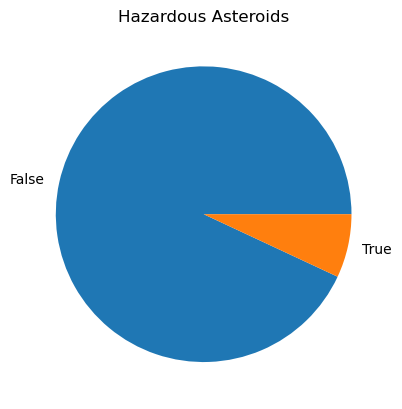

In [14]:
hazardous_graph = data_ast.is_potentially_hazardous_asteroid.value_counts().plot(kind='pie')
hazardous_graph.set(title='Hazardous Asteroids', ylabel='')

In [15]:
data_ast.groupby(['is_potentially_hazardous_asteroid']).median()

,absolute_magnitude_h,is_sentry_object,min_diameter_km,max_diameter_km,relative_velocity_perhour,missing_distance_km
is_potentially_hazardous_asteroid,,,,,,
False,24.62,0.0,0.03,0.07,39490.09,2.644917e+07
True,20.70,0.0,0.19,0.43,59356.49,3.887417e+07


In [16]:
print("The mean of Hazardous Asteroids Minimun diameter in KM is: ", round(hazardous.min_diameter_km.mean(),2))
print("The mean of Hazardous Asteroids Maximun diameter in KM is: ", round(hazardous.max_diameter_km.mean(),2))

The mean of Hazardous Asteroids Minimun diameter in KM is:  0.28
The mean of Hazardous Asteroids Maximun diameter in KM is:  0.62


## Nearest Objects

In [17]:
nearest = data_ast.sort_values('missing_distance_km').head(25)
nearest.value_counts('close_date')

close_date
2022-04-01    2
2022-01-11    1
2022-05-30    1
2022-11-27    1
2022-10-29    1
2022-10-27    1
2022-10-20    1
2022-10-16    1
2022-09-19    1
2022-09-17    1
2022-09-01    1
2022-07-07    1
2022-05-25    1
2022-01-23    1
2022-05-22    1
2022-05-10    1
2022-04-08    1
2022-03-25    1
2022-03-09    1
2022-02-13    1
2022-02-12    1
2022-02-10    1
2022-02-05    1
2022-11-28    1
dtype: int64

<AxesSubplot:xlabel='absolute_magnitude_h', ylabel='missing_distance_km'>

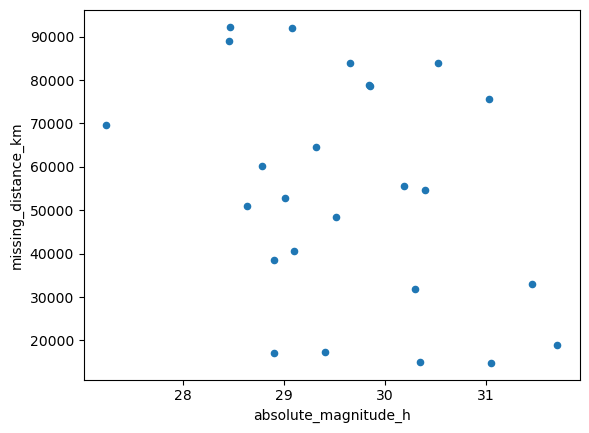

In [18]:
nearest.plot.scatter('absolute_magnitude_h', 'missing_distance_km')

<AxesSubplot:xlabel='relative_velocity_perhour', ylabel='missing_distance_km'>

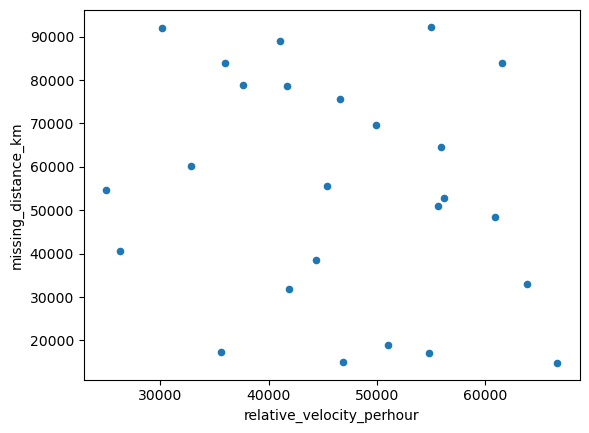

In [19]:
nearest.plot.scatter('relative_velocity_perhour', 'missing_distance_km')

<AxesSubplot:>

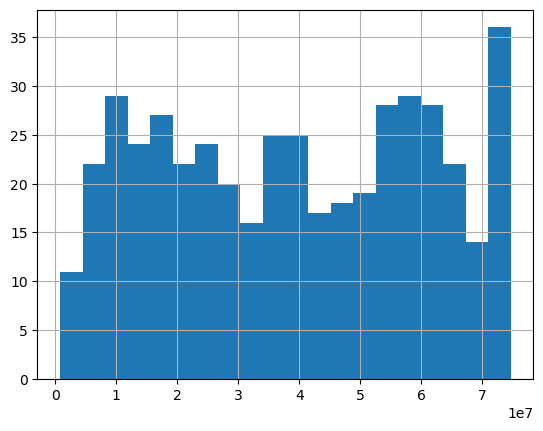

In [20]:
hazardous.missing_distance_km.hist(bins=20)

## Asteroids per month

In [21]:
months = []

for i in data_ast.close_date:
    months.append(i.month)

data_ast['month'] = months

months_haz = []

for i in hazardous.close_date:
    months_haz.append(i.month)

hazardous['month'] = months_haz

/var/folders/kv/d6xc1zws7w7403s69264637m0000gn/T/ipykernel_6771/1222903308.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hazardous['month'] = months_haz


[Text(0.5, 1.0, 'General Asteroides per month'), Text(0, 0.5, 'Asteroids')]

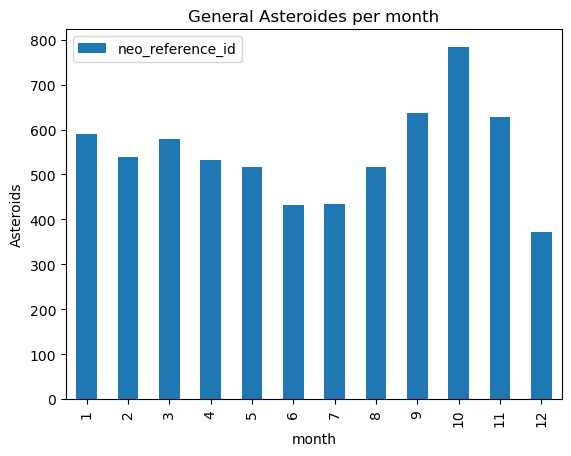

In [22]:
months_gen = data_ast.groupby('month').count()[['neo_reference_id']].sort_values('month').plot(kind='bar')
months_gen.set(title='General Asteroides per month', ylabel='Asteroids')

[Text(0.5, 1.0, 'Hazardous Asteroids per month'), Text(0, 0.5, 'Asteroids')]

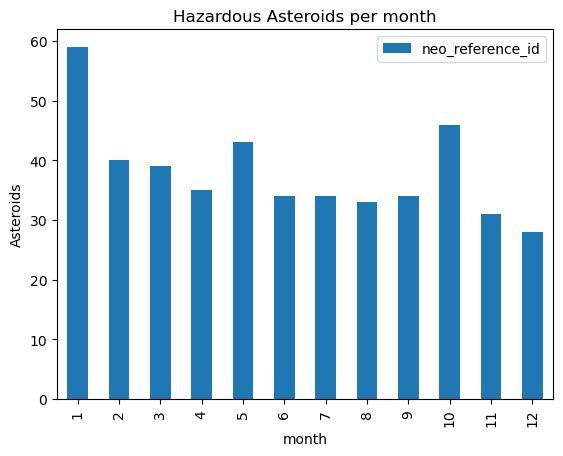

In [23]:
haz_month = hazardous.groupby(hazardous['month']).count()[['neo_reference_id']].plot(kind='bar')
haz_month.set(title='Hazardous Asteroids per month', ylabel='Asteroids')

## Dangerous Distance

According to NASA an asteroid potentially dangerous" any asteroid that passes within 7.5 million kilometers of Earth.

In [24]:
nearest_ast = data_ast[data_ast['missing_distance_km'] < 7500000].sort_values('missing_distance_km')

In [25]:
nearest_ast.head(10)

,id,neo_reference_id,name,nasa_jpl_url,absolute_magnitude_h,is_potentially_hazardous_asteroid,is_sentry_object,min_diameter_km,max_diameter_km,close_date,relative_velocity_perhour,orbit_object,missing_distance_km,month
1511,54264240,54264240,(2022 FD1),http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=54264240,31.050,False,False,0.0,0.00,2022-03-25,66643.38,Earth,14844.54,3
4446,54305651,54305651,(2022 SK4),http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=54305651,30.350,False,False,0.0,0.01,2022-09-19,46822.50,Earth,14921.82,9
5183,54317890,54317890,(2022 UR4),http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=54317890,28.900,False,False,0.0,0.01,2022-10-20,54800.67,Earth,17044.85,10
2584,54281250,54281250,(2022 KP6),http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=54281250,29.410,False,False,0.0,0.01,2022-05-25,35576.40,Earth,17426.49,5
1799,54275865,54275865,(2022 GQ5),http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=54275865,31.710,False,False,0.0,0.00,2022-04-08,51054.09,Earth,18951.27,4
726,54246392,54246392,(2022 CJ5),http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=54246392,30.300,False,False,0.0,0.01,2022-02-10,41878.63,Earth,31849.18,2
4079,54301300,54301300,(2022 RT1),http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=54301300,31.460,False,False,0.0,0.00,2022-09-01,63833.21,Earth,33000.98,9
5427,54322239,54322239,(2022 UW16),http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=54322239,28.900,False,False,0.0,0.01,2022-10-29,44344.41,Earth,38530.68,10
2662,54280768,54280768,(2022 KQ5),http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=54280768,29.100,False,False,0.0,0.01,2022-05-30,26325.66,Earth,40501.93,5
6056,54330579,54330579,(2022 WN9),http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=54330579,29.513,False,False,0.0,0.01,2022-11-27,60943.08,Earth,48384.24,11


[Text(0.5, 1.0, 'Closest asteroids per month'), Text(0, 0.5, 'Asteroids')]

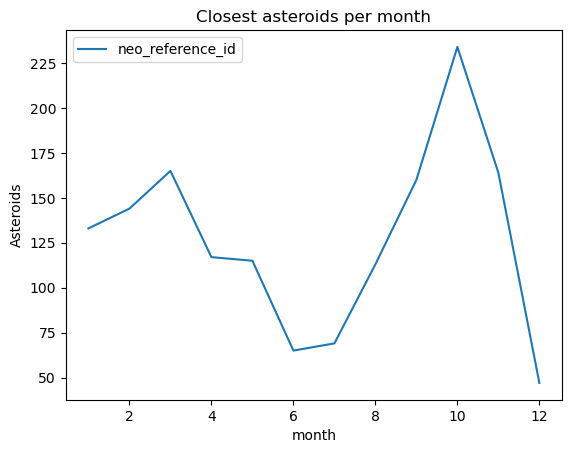

In [26]:
f = nearest_ast.groupby('month').count().sort_values('month')[['neo_reference_id']].plot()
f.set(title='Closest asteroids per month', ylabel='Asteroids')

In [27]:
data_ast

,id,neo_reference_id,name,nasa_jpl_url,absolute_magnitude_h,is_potentially_hazardous_asteroid,is_sentry_object,min_diameter_km,max_diameter_km,close_date,relative_velocity_perhour,orbit_object,missing_distance_km,month
0,54231779,54231779,(2021 YT),http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=54231779,22.73,False,False,0.08,0.17,2022-01-01,15813.99,Earth,40580353.68,1
1,54235478,54235478,(2022 AK1),http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=54235478,22.38,False,False,0.09,0.20,2022-01-01,95980.54,Earth,25682005.25,1
2,54235537,54235537,(2022 AF2),http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=54235537,24.67,False,False,0.03,0.07,2022-01-01,41743.52,Earth,12431720.25,1
3,54235681,54235681,(2022 AM3),http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=54235681,26.57,False,False,0.01,0.03,2022-01-01,24783.95,Earth,3985478.31,1
4,54248460,54248460,(2022 DE2),http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=54248460,19.57,False,False,0.32,0.72,2022-01-01,66890.83,Earth,70318526.11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6556,3825180,3825180,(2018 LM4),http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=3825180,18.76,False,False,0.47,1.05,2023-01-06,68200.50,Earth,57701786.14,1
6557,3986832,3986832,(2020 BT2),http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=3986832,23.67,False,False,0.05,0.11,2023-01-06,85215.24,Earth,63953666.17,1
6558,3989408,3989408,(2020 CN),http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=3989408,27.40,False,False,0.01,0.02,2023-01-06,106028.06,Earth,74174911.15,1
6559,54013568,54013568,(2020 EO),http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=54013568,25.90,False,False,0.02,0.04,2023-01-06,29352.57,Earth,25671748.00,1
